# Gibbs Studies

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Dirichlet Sampling

In [23]:
def dirichlet(rng, counts, alpha_offset=1.):
    """Draw a single sample from a Dirichlet distribution.

    Any bins with zero count (after adding the offset) are effectively ignored
    and have corresponding probabilities zeroed.

    Parameters
    ----------
    counts : array
        1D array of integer bin counts.
    alpha_offset : float
        Used to calculate the Dirichlet concentration parameters from the prior
        plus previous (z,t) bin counts. A value of 0 results in samples with a
        posterior mean of nbin / ntot for each bin, but will always return 0
        when nbin=0.  A value of 1 results in samples with a posterior mode of
        nbin / ntot for each bin, and generates random f > 0 when nbin=0 with
        a corresponding decrease in f for bins with nbin>0 in order to satisify
        sum(f) = 1.

    Returns
    -------
    array
        1D array of probabilities associated with each bin, which sum to one.
    """
    alpha = counts + alpha_offset
    nonzero = alpha != 0
    if np.any(nonzero):
        probs = np.zeros_like(alpha)
        probs[nonzero] = rng.dirichlet(alpha[nonzero], size=1)[0]
    else:
        probs = rng.dirichlet(alpha, size=1)[0]
    return probs

In [24]:
def dirtest(ax=None, dalpha=1., nprior=100, nsample=10000, nbins=50, seed=123):
    ax = ax or plt.gca()
    bins = np.linspace(-10, 10, nbins + 1)
    rng = np.random.RandomState(seed)
    xprior = rng.normal(size=nprior)
    prior, _ = np.histogram(xprior, bins=bins)
    ax.plot(prior, 'r.')
    sample = np.stack([dirichlet(rng, prior, dalpha) for i in range(nsample)])
    ax.plot(nprior * sample[0], 'b.')
    ax.plot(nprior * np.mean(sample, axis=0), 'b-', alpha=0.5,
            label='$\\alpha=n+{}$'.format(dalpha))
    ax.legend()

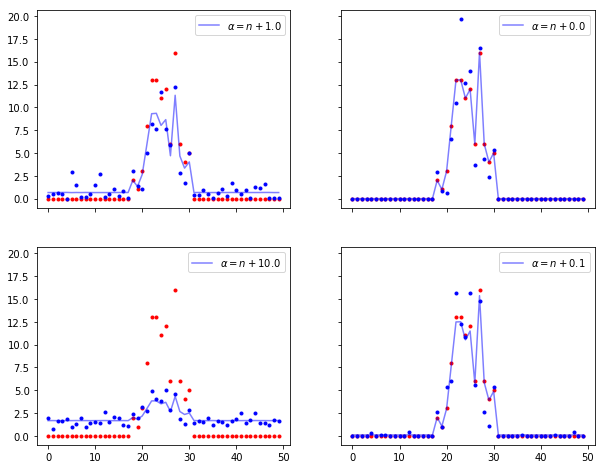

In [26]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
dirtest(ax[0, 0], 1.0)
dirtest(ax[0, 1], 0.0)
dirtest(ax[1, 0], 10.0)
dirtest(ax[1, 1], 0.1)

## Categorical Sampling

Test different methods for sampling the categorical distribution since this is the bottleneck for Gibbs sampling:

In [322]:
def categorical(probs, rng=None, method='choice'):
    """Sample from one or more categorical distributions.
    """
    rng = rng or np.random.RandomState()
    probs = np.asarray(probs)
    # How many categories are there?
    ncat = probs.shape[-1]
    # Normalize along last axis.
    probs /= probs.sum(axis=-1, keepdims=True)
    # Methods that do not broadcast over independent probs, so need a list comprehension.
    if method in ('choice', 'multinomial', 'searchsorted', 'argmax'):
        # Method to generate a single category.
        generate_one = {
            'choice': (lambda p: rng.choice(ncat, p=p)),
            'multinomial': (lambda p: np.argwhere(rng.multinomial(1, p))[0, 0]),
            'searchsorted': (lambda p: np.searchsorted(p.cumsum(), rng.uniform())),
            'argmax': (lambda p: np.argmax(p.cumsum() > rng.uniform())),
        }[method]
        if probs.ndim > 1:
            output_shape = probs.shape[:-1]
            return np.array([generate_one(p) for p in probs.reshape(-1, ncat)]).reshape(output_shape)
        else:
            return generate_one(probs)
    elif method == 'vsearchsorted':
        # This is a vectorized version of searchsorted above, using a trick adapted from
        # https://stackoverflow.com/a/40588862/4726728
        cdfs = probs.cumsum(axis=-1)
        output_shape = probs.shape[:-1]
        u = rng.uniform(size=output_shape + (1,))
        offset = np.arange(u.size)
        idx = np.searchsorted((cdfs + offset[:, np.newaxis]).reshape(-1), u.reshape(-1) + offset)
        return (idx - ncat * offset).reshape(output_shape)
    elif method == 'vargmax':
        # This is a vectorized version of argmax above.
        # Note that it doesn't take advantage of the fact that cdfs is sorted along axis=-1.
        cdfs = probs.cumsum(axis=-1)
        u = rng.uniform(size=probs.shape[:-1] + (1,))
        return np.argmax(cdfs > u, axis=-1)
    elif method == 'gumbel':
        # https://en.wikipedia.org/wiki/Categorical_distribution#Sampling_via_the_Gumbel_distribution
        with np.errstate(divide='ignore'):
            # Ignore log(0) = -inf warnings
            gamma = np.log(probs)
        u = rng.uniform(size=probs.shape)
        g = -np.log(-np.log(u))
        return np.argmax(gamma + g, axis=-1)

In [335]:
def test_categorical(method, n=100000, ncat=100, seed=123):
    rng = np.random.RandomState(seed)
    probs = rng.uniform(size=ncat)
    probs /= probs.sum()
    all_probs = np.asarray([probs] * n)
    start = time.time()
    cats = categorical(all_probs, rng, method)
    elapsed = time.time() - start
    print(f'Elapsed time for {n}x{ncat} "{method}" samples: {elapsed:.3f}s.')
    counts = np.bincount(cats, minlength=len(probs))
    plt.plot(counts / n - probs, '+', label=method)
    plt.axhline(0.)
    #plt.plot(probs, 'o', label='Probs')
    plt.legend()

Elapsed time for 100000x100 "choice" samples: 1.696s.


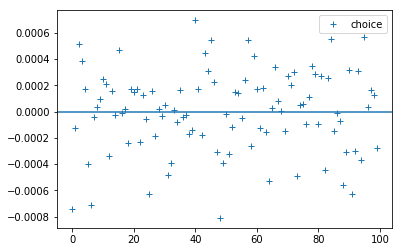

In [336]:
test_categorical('choice')

Elapsed time for 100000x100 "multinomial" samples: 0.767s.


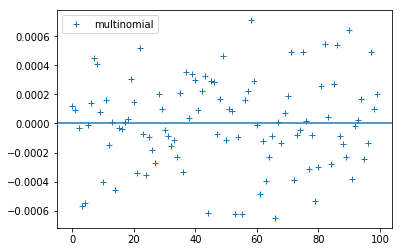

In [337]:
test_categorical('multinomial')

Elapsed time for 100000x100 "searchsorted" samples: 0.335s.


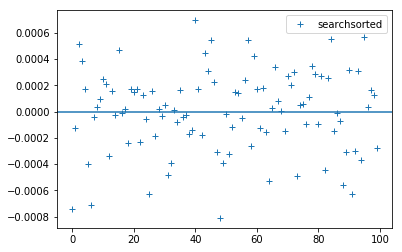

In [338]:
test_categorical('searchsorted')

Elapsed time for 100000x100 "argmax" samples: 0.381s.


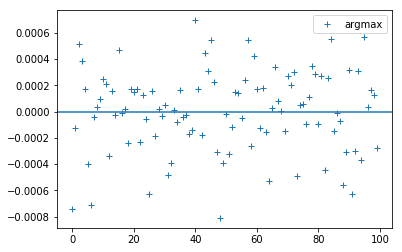

In [339]:
test_categorical('argmax')

Elapsed time for 100000x100 "vsearchsorted" samples: 0.228s.


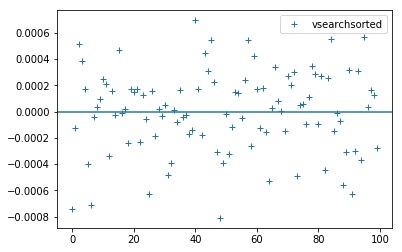

In [340]:
test_categorical('vsearchsorted')

Elapsed time for 100000x100 "vargmax" samples: 0.068s.


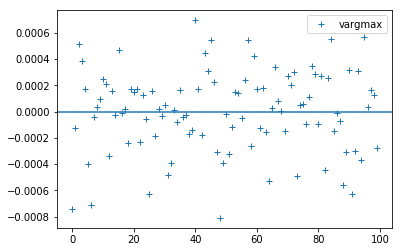

In [341]:
test_categorical('vargmax')

Elapsed time for 100000x100 "gumbel" samples: 0.265s.


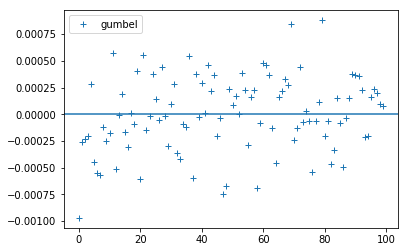

In [342]:
test_categorical('gumbel')

## Gelman Rubin Convergence Metric

Based on https://rlhick.people.wm.edu/stories/bayesian_5.html

In [344]:
def gr_metric(*samples, idx=0, burnin=0):
    mu, var = [], []
    n = 0
    for sample in samples:
        # Pick out the requested 
        X = sample[burnin:, idx]
        if n:
            assert len(X) == n, 'Expected all samples to have the same length.'
        else:
            n = len(X)
        mu.append(X.mean())
        var.append(X.var())
    mu = np.array(mu)
    mu_all = np.mean(mu)
    B = n * np.sum((mu - mu_all) ** 2)
    W = np.mean(var)
    var_theta = (1 - 1 / n) * W + B / n
    return np.sqrt(var_theta / W)

## Sample Compression

Utility to convert samples written with 8-byte ints to 2-byte ints (which are big enough for nz * nt < 2 ** 16):

In [348]:
def to16(name):
    big = np.load(name + '.npy')
    assert big.dtype == np.int64
    small = big.astype(np.uint16)
    assert np.array_equal(big, small)
    np.save(name, small)

## Progress Bar

In [43]:
import time, sys
import IPython.display

class ProgressBar(object):
    """Replace existing contents of the current output cell with a progress bar.
    """
    def __init__(self, maxval=1., label='Progress', width=40):
        self.maxval = maxval
        self.label = label
        self.width = width
        self.start_at = time.time()
        self.update(0.)
    def update(self, value):
        elapsed = int(round(time.time() - self.start_at))
        mins = elapsed // 60
        secs = elapsed % 60
        timing = '{mins}m{secs:02d}s'.format(mins=mins, secs=secs)
        frac = value / self.maxval
        ndone = int(round(frac * self.width))
        bar = '#' * ndone + '-' * (self.width - ndone)
        text = '{label}: [{bar}]{pct:5.1f}% {timing}'.format(
            label=self.label, bar=bar, pct=100 * frac, timing=timing)
        IPython.display.clear_output(wait=True)
        print(text)

In [42]:
print('Before...') # will be replaced by progress bar
bar = ProgressBar(10)
for i in range(10):
    time.sleep(1)
    bar.update(i + 1)
print('Done!') # appears below the progress bar

Progress: [########################################]100.0% 0m10s
Done!
